# ARR Analysis

## Goal

ARR prediction, where ARR=RoomIncome_Main/room_nights

## Roadmap

1. Load dataset + Cleaning
- Exploratory Data Analysis (EDA)
    - High level statistics
    - Features Histograms
    - Data Encoding (categorigal+numeric)
    - Correlation Matrix
- Basic Modelling
    - Linear Regression
    - Ridge (L2)
    - Lasso (L1)
    - Elastic-Net (L1+L2)
    - Support Vector Regression (SVR)
- Trees
    - Decision Trees
    - Random Forest (ensemble)
    - XGBoost (boosted)
- Neural Networks
    - Multi-layer Perceptron
    - Tensorflow ANN
- Statistical Forcasting
    - SARIMAX
    - FBProphet
 
<br><br>
<div><img src="https://miro.medium.com/max/1400/1*OmxKKDqcVm_UCOYT9i5TJw.png" width=750"/></div>

<hr>

# Initialization

Import required libraries

In [1]:
import glob
import joblib
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from os import path
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


User Parameters:

In [2]:
dataset_path = "../EDA/data/res*.csv"
events_path = '../EDA/events.xls'
save_path = 'saved_data/'
scaling_mode = "standard"
hyper_params_en = False
overwrite_saved_data = False

index_var = 'res_date'
dependent_var ='ARR'

m_lead_days_max = 300
room_nights_min = 0
room_nights_max = 7
RoomIncome_Main_min = 0
RoomIncome_Main_max = 4000
dependent_var_max = 3000

models = ['linear_regressor',       # 0
          'ridge_regressor',        # 1
          'lasso_regressor',        # 2
          'elasticnet_regressor',   # 3
          'supportvect_regressor',  # 4 
          'decisiontree_regressor', # 5
          'randomforest_regressor', # 6
          'xgboost_regressor',      # 7
          'mlp_regressor']          # 8

External parameters:

In [3]:
if not 'hotel_sel' in locals():
    hotel_sel = 546.0 

Load dataset

In [4]:
all_files = glob.glob(dataset_path)

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(df)

reservations_data = pd.concat(li, axis=0, ignore_index=True)

Load special events

In [5]:
events_df = pd.read_excel(events_path)
print('events_df', events_df.shape)
display(events_df.head())

events_df (230, 7)


,FairId,FairName,FromDate,ToDate,HotelId,Unnamed: 5,OFFICE
0,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,554,NaN,1
1,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,555,NaN,1
2,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,960,NaN,1
3,1,פסטיבל הג'אז חורף אילת,2017-02-09,2017-02-10,554,NaN,1
4,1,פסטיבל הג'אז חורף אילת,2017-02-09,2017-02-10,555,NaN,1


Focus on relevant attributes + Cleaning

In [6]:
reservations_data2 = reservations_data.copy()

# Clean (filter):
reservations_data2 = reservations_data2[(reservations_data2['m_lead_days']<m_lead_days_max) &
                                        (reservations_data2['room_nights']>room_nights_min) & 
                                        (reservations_data2['room_nights']<room_nights_max) &
                                        (reservations_data2['RoomIncome_Main']>RoomIncome_Main_min) &
                                        (reservations_data2['RoomIncome_Main']<RoomIncome_Main_max)]

# Extract relevant features only:
reservations_data2 = reservations_data2[['res_date',
                                         'plan_desc',
                                         'RoomTypes_desc',
                                         'market_segment_bi_id',
                                         'MainCust',
                                         'source',
                                         'sales_channel',
                                         'club_code',
                                         'StatisticSource',
                                         'package_code',
                                         'nationality',
                                         'group_member',
                                         'm_length_of_stay',
                                         'bed_nights',
                                         'm_lead_days',
                                         'adults',
                                         'juniors',
                                         'children',
                                         'babies', 
                                         'hotel']]

# Add 'is_event' sideband feature:
s1 = events_df['HotelId'].values
s2 = events_df['FromDate'].values
s3 = events_df['ToDate'].values
s = pd.to_datetime(reservations_data2['res_date'], errors='coerce').values[:,None]
reservations_data2['is_event'] = (np.dot(((s1==hotel_sel)|(s1==0))&(s>=s2)&(s<=s3), events_df.FairId) > 0)
reservations_data2['is_event'] = reservations_data2['is_event'].astype(int)

# Dependent variable:
reservations_data2[dependent_var] = (reservations_data['RoomIncome_Main'] / reservations_data['room_nights']).fillna(0)

# Additional cleanup (dependent variable related):
reservations_data2 = reservations_data2[(reservations_data2[dependent_var] < dependent_var_max)]

Focus on a spefici hotel

In [7]:
hotels = reservations_data2['hotel'].unique()
hotels = np.sort(hotels[~np.isnan(hotels)])
print('Hotels:\n%s\n' % str(hotels))
print('Selected: %s\n' % str(hotel_sel))

reservations_df = reservations_data2[reservations_data2['hotel'] == hotel_sel]
reservations_df = reservations_df.drop(['hotel'], axis=1)
reservations_df = reservations_df.set_index(index_var)

Hotels:
[542. 543. 545. 546. 547. 548. 549. 550. 551. 552. 554. 555. 643. 956.
 957. 960.]

Selected: 546.0



Data Cleaning

In [8]:
for col in reservations_df:
    dt = reservations_df[col].dtype 
    if dt == int or dt == float:
        reservations_df[col] = reservations_df[col].fillna(0)
    else:
        reservations_df[col] = reservations_df[col].fillna("")

Debug mixed types cases

In [9]:
%%script false --no-raise-error

df = pd.DataFrame(reservations_df['nationality'])
weird = (df.applymap(type) != df.iloc[0].apply(type)).any(axis=1)
display(df[weird])

<hr>

# Data Exploration

### Quick look:

In [10]:
print('reservations_df shape: %s' % str(reservations_df.shape))
display(reservations_df.head())

reservations_df shape: (84439, 20)


,plan_desc,RoomTypes_desc,market_segment_bi_id,MainCust,source,sales_channel,club_code,StatisticSource,package_code,nationality,group_member,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,is_event,ARR
res_date,,,,,,,,,,,,,,,,,,,,
2018-10-04,breakfast board,garden chalet,15.0,12845.0,dan,,,,,isr,0.0,2.0,2.0,156.0,2.0,0.0,0.0,0.0,0,1266.72
2018-10-05,breakfast board,garden chalet,15.0,12845.0,dan,,,,,isr,0.0,2.0,2.0,156.0,2.0,0.0,0.0,0.0,0,1266.72
2018-10-04,breakfast board,garden chalet,15.0,12845.0,dan,,,,,isr,0.0,1.0,2.0,156.0,2.0,0.0,0.0,0.0,0,1266.72
2018-10-04,breakfast board,garden chalet,15.0,12845.0,dan,,,,,isr,0.0,1.0,2.0,156.0,2.0,0.0,0.0,0.0,0,1266.72
2018-10-04,breakfast board,garden chalet,15.0,12845.0,dan,,,,,isr,0.0,1.0,2.0,156.0,2.0,0.0,0.0,0.0,0,1266.72


In [11]:
reservations_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84439 entries, 2018-10-04 to 2019-06-30
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   plan_desc             84439 non-null  object 
 1   RoomTypes_desc        84439 non-null  object 
 2   market_segment_bi_id  84439 non-null  float64
 3   MainCust              84439 non-null  float64
 4   source                84439 non-null  object 
 5   sales_channel         84439 non-null  object 
 6   club_code             84439 non-null  object 
 7   StatisticSource       84439 non-null  object 
 8   package_code          84439 non-null  object 
 9   nationality           84439 non-null  object 
 10  group_member          84439 non-null  float64
 11  m_length_of_stay      84439 non-null  float64
 12  bed_nights            84439 non-null  float64
 13  m_lead_days           84439 non-null  float64
 14  adults                84439 non-null  float64
 15  juniors   

### Encode the dataset

In [12]:
dependent_series = reservations_df[dependent_var]
encoded_pre_df = reservations_df.drop([dependent_var], axis=1)

# Label Encoding:
enc_lbl = LabelEncoder()
encoded_categorical_df = encoded_pre_df.select_dtypes(include=['object']).apply(enc_lbl.fit_transform)

# OneHot Encoding:
enc_oh = OneHotEncoder(handle_unknown='ignore')
encoded_categorical_oh_df = pd.DataFrame(enc_oh.fit_transform(encoded_categorical_df).toarray(), index=reservations_df.index)
encoded_categorical_oh_df.columns = enc_oh.get_feature_names(encoded_categorical_df.columns)

# Numerical Features:
encoded_numerical_df = encoded_pre_df.select_dtypes(exclude=['object'])

# Merge back into a single dataframe:
encoded_df = pd.concat([encoded_categorical_oh_df, encoded_numerical_df], axis=1, sort=False)
    
print(encoded_df.shape)
display(encoded_df.head())
display(encoded_df.describe())

(84439, 205)


,plan_desc_0,plan_desc_1,plan_desc_2,plan_desc_3,plan_desc_4,plan_desc_5,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,...,MainCust,group_member,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,is_event
res_date,,,,,,,,,,,,,,,,,,,,,
2018-10-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12845.0,0.0,2.0,2.0,156.0,2.0,0.0,0.0,0.0,0
2018-10-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12845.0,0.0,2.0,2.0,156.0,2.0,0.0,0.0,0.0,0
2018-10-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12845.0,0.0,1.0,2.0,156.0,2.0,0.0,0.0,0.0,0
2018-10-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12845.0,0.0,1.0,2.0,156.0,2.0,0.0,0.0,0.0,0
2018-10-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12845.0,0.0,1.0,2.0,156.0,2.0,0.0,0.0,0.0,0


,plan_desc_0,plan_desc_1,plan_desc_2,plan_desc_3,plan_desc_4,plan_desc_5,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,...,MainCust,group_member,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,is_event
count,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,...,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000,84439.000000
mean,0.000047,0.822499,0.003091,0.041024,0.132628,0.000711,0.000012,0.002463,0.054584,0.042433,...,8981.506816,0.216961,5.243335,1.546501,39.772510,1.387901,0.000071,0.158529,0.037518,0.125215
std,0.006883,0.382094,0.055511,0.198346,0.339175,0.026647,0.003441,0.049571,0.227167,0.201576,...,2851.634048,0.412179,4.958819,0.716112,54.965824,0.568593,0.008429,0.526090,0.199811,0.330964
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7924.000000,0.000000,2.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9482.000000,0.000000,4.000000,1.000000,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10539.000000,0.000000,7.000000,2.000000,46.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,13186.000000,1.000000,96.000000,4.000000,298.000000,4.000000,1.000000,4.000000,3.000000,1.000000


### Histogram Analysis

Dependent variable histogram

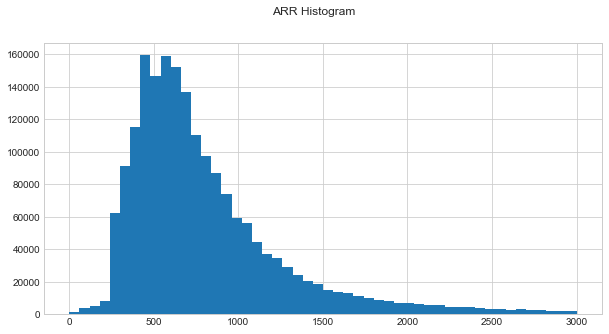

ARR min, mean, max = 0.01, 802.23, 2999.99
ARR uniques (87157):
 [1.00000e-02 2.00000e-02 3.00000e-02 ... 2.99937e+03 2.99943e+03
 2.99999e+03]


In [13]:
plt.style.use('seaborn-whitegrid')
reservations_data2[dependent_var].hist(bins=50, figsize=(10,5))
plt.suptitle('%s Histogram' % dependent_var)
plt.show()

s = reservations_data2[dependent_var]
s_unique = np.sort(s.unique())
print('%s min, mean, max = %.2f, %.2f, %.2f' % (dependent_var,min(s),np.mean(s),max(s)))
print('%s uniques (%d):\n %s' % (dependent_var, len(s_unique), str(s_unique)))

Features Histograms

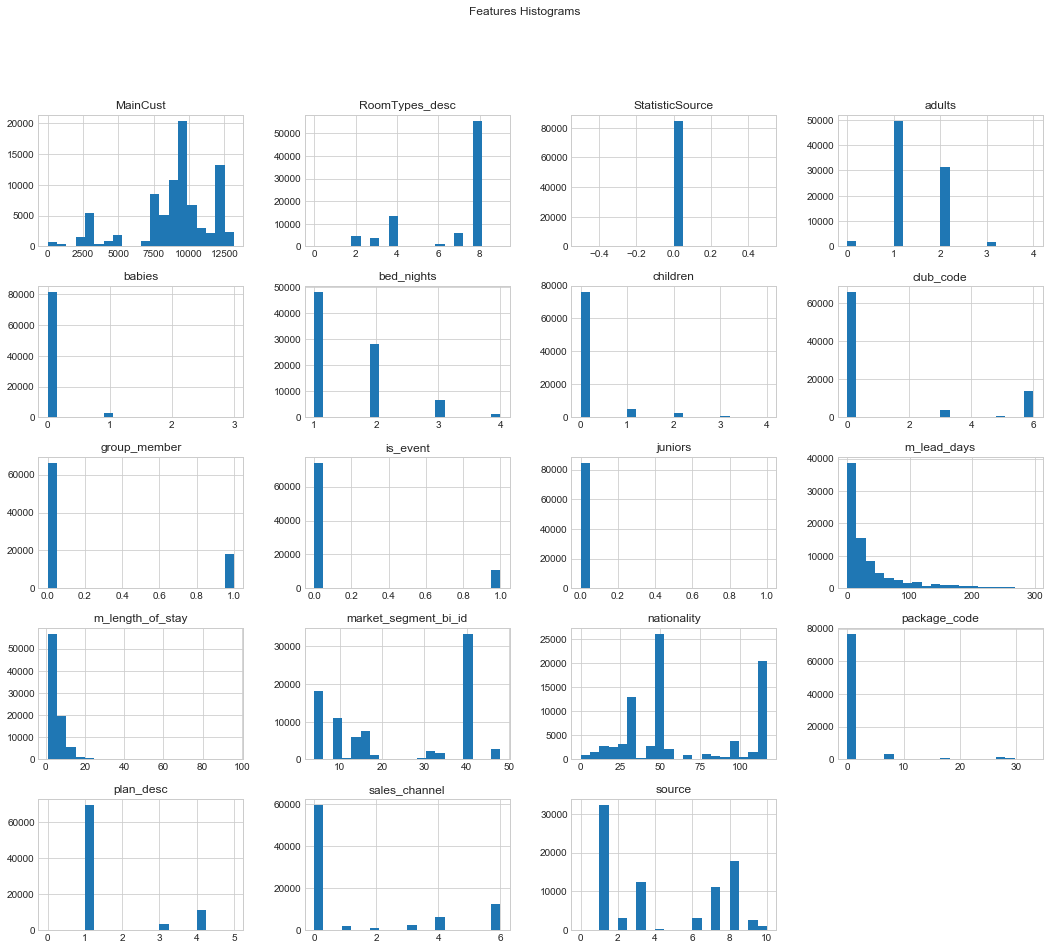

In [14]:
plt.style.use('seaborn-whitegrid')
encoded_hist_df = pd.concat([encoded_categorical_df, encoded_numerical_df], axis=1, sort=False)
encoded_hist_df.hist(bins=20, figsize=(18,15))
plt.suptitle('Features Histograms')
plt.show()

### Correlation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.<br>
The __Pearson__ and __Spearman__ correlation coefficients can range in value from −1 to +1 ([link](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)).<br>
The __Pearson__ correlation evaluates the __linear__ relationship between two continuous variables.<br>
The __Spearman__ correlation evaluates the __monotonic__ relationship between two continuous or ordinal variables.

In [15]:
encoded_df2 = pd.concat([encoded_df, dependent_series], axis=1)

Relevant Features (Pearson):

RoomTypes_desc_2        0.270348
RoomTypes_desc_7        0.465910
RoomTypes_desc_8        0.598804
source_1                0.485644
source_3                0.246067
source_7                0.339966
source_8                0.362200
sales_channel_4         0.382864
sales_channel_6         0.245720
club_code_0             0.311833
club_code_6             0.275784
package_code_0          0.276498
market_segment_bi_id    0.484323
bed_nights              0.597265
adults                  0.435190
children                0.342748
is_event                0.264723
ARR                     1.000000
Name: ARR, dtype: float64 

Relevant Features (Spearman):

plan_desc_1             0.205531
RoomTypes_desc_2        0.250231
RoomTypes_desc_7        0.374355
RoomTypes_desc_8        0.580237
source_1                0.499220
source_3                0.277788
source_7                0.338186
source_8                0.384598
sales_channel_4         0.345959
sales_channel_6     

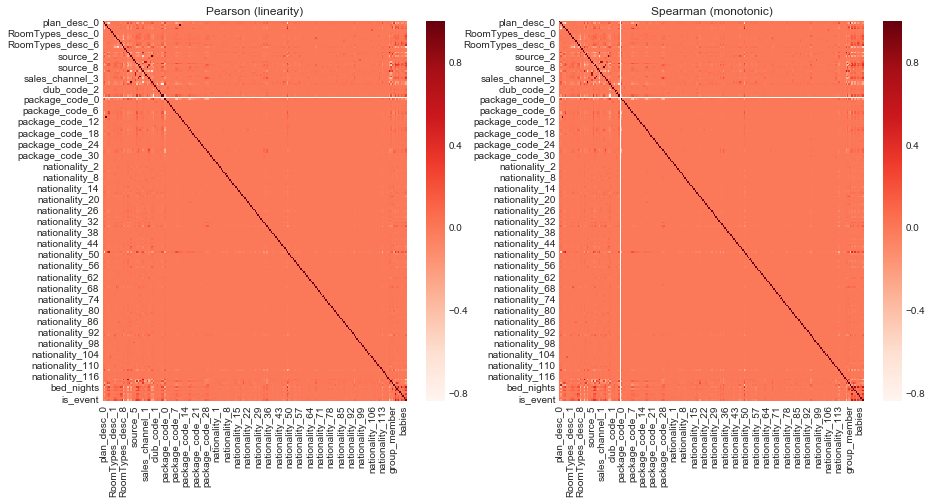

In [16]:
pearson_cor = encoded_df2.corr(method='pearson')
spearman_cor = encoded_df2.corr(method='spearman')

# Highlight relevant features
pearson_cor_targets = abs(pearson_cor[dependent_var])
spearman_cor_targets = abs(spearman_cor[dependent_var])
print('Relevant Features (Pearson):\n')
print(pearson_cor_targets[pearson_cor_targets > 0.2], '\n')
print('Relevant Features (Spearman):\n')
print(spearman_cor_targets[spearman_cor_targets > 0.2])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.heatmap(pearson_cor, ax=ax1, annot=False, cmap=plt.cm.Reds)
sns.heatmap(spearman_cor, ax=ax2, annot=False, cmap=plt.cm.Reds)
ax1.set_title('Pearson (linearity)')
ax2.set_title('Spearman (monotonic)')
plt.show()

In [17]:
%%script false --no-raise-error

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(pearson_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Pearson (monotonic)')
plt.show()

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(spearman_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Spearman (monotonic)')
plt.show()

<hr>

# Basic Modelling

Linear Modelling:

![](https://miro.medium.com/max/1400/1*0W935wbGEcLZoqXIxkuhTQ.png)

### Normalization

In [18]:
min_max_scaler = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
encoded_scl_df = pd.DataFrame(min_max_scaler.fit_transform(encoded_df), columns=encoded_df.columns)

encoded_scl_df.describe()

,plan_desc_0,plan_desc_1,plan_desc_2,plan_desc_3,plan_desc_4,plan_desc_5,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,...,MainCust,group_member,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,is_event
count,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,...,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04,8.443900e+04
mean,-1.430527e-18,-1.602190e-16,-2.356162e-18,2.490800e-17,-5.048919e-18,-1.750292e-17,1.514676e-18,5.385513e-18,-2.558119e-17,-3.231308e-17,...,2.598510e-16,1.332915e-16,-5.250875e-17,-2.315771e-16,7.135805e-17,2.167669e-16,-2.356162e-18,2.356162e-17,3.803519e-17,-7.438740e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-6.882857e-03,-2.152620e+00,-5.568279e-02,-2.068300e-01,-3.910348e-01,-2.666603e-02,-3.441367e-03,-4.969305e-02,-2.402815e-01,-2.105074e-01,...,-3.150320e+00,-5.263803e-01,-8.557199e-01,-7.631550e-01,-7.235905e-01,-2.440952e+00,-8.429844e-03,-3.013357e-01,-1.877695e-01,-3.783353e-01
25%,-6.882857e-03,4.645501e-01,-5.568279e-02,-2.068300e-01,-3.910348e-01,-2.666603e-02,-3.441367e-03,-4.969305e-02,-2.402815e-01,-2.105074e-01,...,-3.708446e-01,-5.263803e-01,-6.540578e-01,-7.631550e-01,-6.144311e-01,-6.822161e-01,-8.429844e-03,-3.013357e-01,-1.877695e-01,-3.783353e-01
50%,-6.882857e-03,4.645501e-01,-5.568279e-02,-2.068300e-01,-3.910348e-01,-2.666603e-02,-3.441367e-03,-4.969305e-02,-2.402815e-01,-2.105074e-01,...,1.755121e-01,-5.263803e-01,-2.507336e-01,-7.631550e-01,-4.143055e-01,-6.822161e-01,-8.429844e-03,-3.013357e-01,-1.877695e-01,-3.783353e-01
75%,-6.882857e-03,4.645501e-01,-5.568279e-02,-2.068300e-01,-3.910348e-01,-2.666603e-02,-3.441367e-03,-4.969305e-02,-2.402815e-01,-2.105074e-01,...,5.461789e-01,-5.263803e-01,3.542527e-01,6.332833e-01,1.132982e-01,1.076520e+00,-8.429844e-03,-3.013357e-01,-1.877695e-01,-3.783353e-01
max,1.452885e+02,4.645501e-01,1.795887e+01,4.834889e+00,2.557317e+00,3.750089e+01,2.905822e+02,2.012354e+01,4.161786e+00,4.750428e+00,...,1.474424e+00,1.899767e+00,1.830218e+01,3.426160e+00,4.697992e+00,4.593993e+00,1.186262e+02,7.301976e+00,1.482650e+01,2.643158e+00


### Cross Validation (Train/Test split)

R-squared (R²), Mean Squared Error (MSE), Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are the most commonly used metrics to measure accuracy for continuous variables.<br>
The focus here is on R-Squared, aka the coefficient of determination, which implies how much variance in the target variable can be explained by the model.<br>
Values can range from 0 to 1. Higher values indicate a model that is highly predictive.<br>
For example, a R² value of 0.80 means that the model is accounting for 80% of the variability in the data.<br>
In general, the higher the R² value the better. However, a very high R² could be a sign of overfitting. <br>
Low values indicate that our model is not very good at predicting the target.<br>

<div><img src="https://miro.medium.com/max/2000/1*RZ7wWxTZxb6ySGGWJaY-CQ.jpeg" width=800"/></div>

In [19]:
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')

    print('CV Mean Accuracy: ', np.mean(scores))
    print('CV STD Accuracy: ', np.std(scores), '\n')

Split the data into training and testing with a ratio of 80% and 20%

In [20]:
X_train, X_test, y_train, y_test = train_test_split(encoded_scl_df, dependent_series, test_size=0.2, random_state=27)

### Auxiliary methods

In [21]:
def plot_model(model, X_train, y_train, y_test, y_pred):
    y_pred_train = model.predict(X_train)

    plt.figure(figsize=(16,8))
    
    plt.subplot(121)
    plt.scatter(y_train, y_pred_train)
    plt.plot(y_train, y_train, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Train-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.subplot(122)
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Test-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")
    
    plt.show()

In [22]:
def plot_tree_features_importance(feature_importances, feature_labels, threshold):
    feature_import_val = feature_importances[feature_importances > threshold]
    feature_import_lbl = feature_labels[feature_importances > threshold]

    plt.figure(figsize=(12,6))
    plt.bar(feature_import_lbl, feature_import_val)
    plt.xticks(rotation='vertical')
    plt.title('Features Importance')
    plt.show()

In [23]:
def plot_partial_dependencies(model, X_train, target_features):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies")
    plot_partial_dependence(model, X_train, target_features, ax=ax, line_kw={"c": "red"})

In [24]:
def print_model_accuracy(model, X_train, y_train, X_test, y_test):
    print('Train Accuracy: ', model.score(X_train, y_train))
    print('Test Accuracy: ', model.score(X_test, y_test))

<hr>

<hr>

### Linear Regressor

Linear regression finds the parameters to minimize the mean squared error or residuals between the predictions and the targets.<br>

<div><img src="https://gohantimes.com/wp-content/uploads/2019/11/ols-sum-of-square-diff.png" width="500"/></div>

Model: linear_regressor
CV Mean Accuracy:  -6.049648935519281e+24
CV STD Accuracy:  6.842098924431062e+24 

Train Accuracy:  0.7359768775873614
Test Accuracy:  -2.3417761413789524e+25


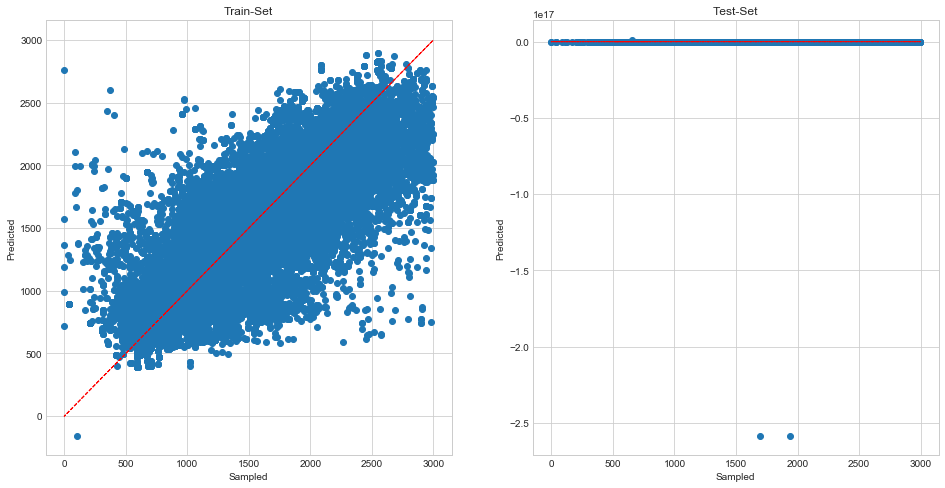

In [25]:
model_name = models[0]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = LinearRegression(n_jobs=4)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

Examine the coefficients:

In [26]:
for coef, col in enumerate(X_train.columns):
    print('%s --> %.2f' % (col, model.coef_[coef]))

plan_desc_0 --> 6695578819351.69
plan_desc_1 --> 371713189319869.38
plan_desc_2 --> 54002819189054.09
plan_desc_3 --> 192957337238395.81
plan_desc_4 --> 329959523281828.75
plan_desc_5 --> 25923264411882.25
RoomTypes_desc_0 --> 4016388908014.45
RoomTypes_desc_1 --> 57854139153123.60
RoomTypes_desc_2 --> 265126542774615.41
RoomTypes_desc_3 --> 235259039960288.75
RoomTypes_desc_4 --> 427954338980527.56
RoomTypes_desc_5 --> 38082724749848.96
RoomTypes_desc_6 --> 134807645050170.75
RoomTypes_desc_7 --> 298533737664181.06
RoomTypes_desc_8 --> 554635550515970.62
RoomTypes_desc_9 --> 4016388908008.77
source_0 --> -6373205320824.38
source_1 --> -899874287424946.00
source_2 --> -354104973176961.94
source_3 --> -657153561011645.12
source_4 --> -94621001331427.84
source_5 --> -61096688956568.06
source_6 --> -352351085276339.75
source_7 --> -629415025313673.25
source_8 --> -757805704807802.12
source_9 --> 507444269175356.25
source_10 --> -208387470162795.47
sales_channel_0 --> 912420138822808.62
sa

#### Plot partial dependencies
Partial dependence plots (PDP) show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.<br>
[reference](https://www.kaggle.com/dansbecker/partial-dependence-plots)

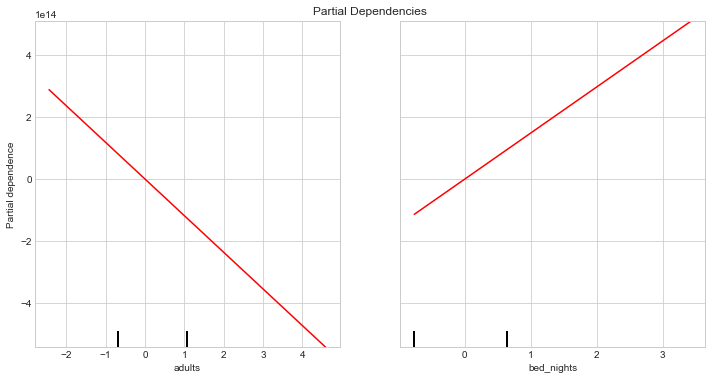

In [27]:
plot_partial_dependencies(model, X_train, ["adults", "bed_nights"])

We can clearly see a linear relationship among these featrues.<br>
Note that PDPs assume that the target features are independent from the complement features, and this assumption is often violated in practice.

<hr>

### Ridge Regressor

Ridge regression uses L2 regularization to minimize the magnitude of the coefficients.<br>
It reduces the size of the coefficients and helps reduce model complexity.<br>
We control the complexity of our model with the regularization parameter, ⍺.<br>
Higher values of ⍺ force coefficients to move towards zero and increases the restriction on the model.<br>
This decreases training performance, but also increases the generalizability of the model. 

Model: ridge_regressor
CV Mean Accuracy:  0.7342336157403879
CV STD Accuracy:  0.0025147446165490724 

Train Accuracy:  0.7360948791201689
Test Accuracy:  0.7366445731906655


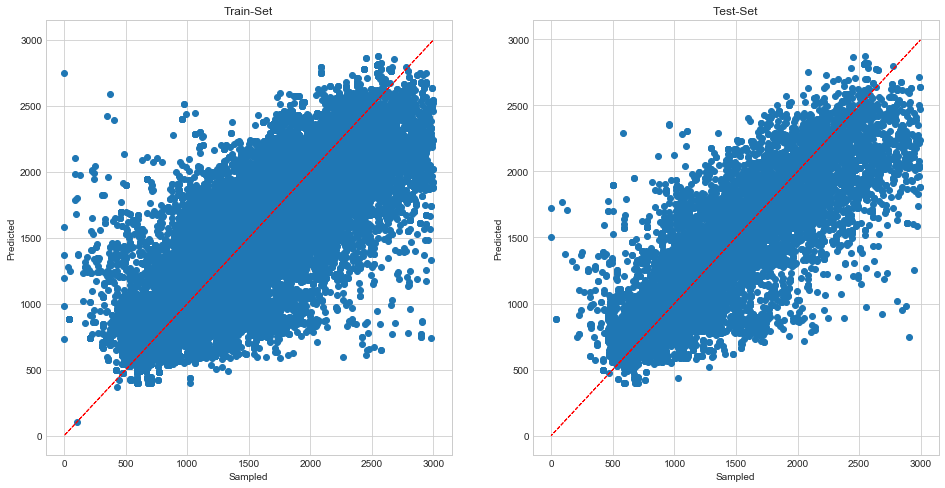

In [28]:
model_name = models[1]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = Ridge(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)    
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

<hr>

### Lasso Regressor

Lasso regression uses L1 regularization to force some coefficients to be exactly zero.<br>
This means some features are completely ignored by the model. <br>
This can be thought of as a type of automatic feature selection!<br>
Lasso can be a good model choice when we have a large number of features but expect only a few to be important.<br>
Higher values of ⍺ force more coefficients to zero and can cause underfitting.<br>
Lower values of alpha lead to fewer non-zero features and can cause overfitting.<br>
Very low values of alpha will cause the model to resemble linear regression.

Model: lasso_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2724713.8707466125, tolerance: 2250510.1929754675
  positive)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112592595.71960211, tolerance: 1802032.7423921414
  positive)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47330691.85839605, tolerance: 1802221.3968028047
  positive)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

CV Mean Accuracy:  0.7343110933196358
CV STD Accuracy:  0.0025232177963220707 

Train Accuracy:  0.7360876142094701
Test Accuracy:  0.736665509123873


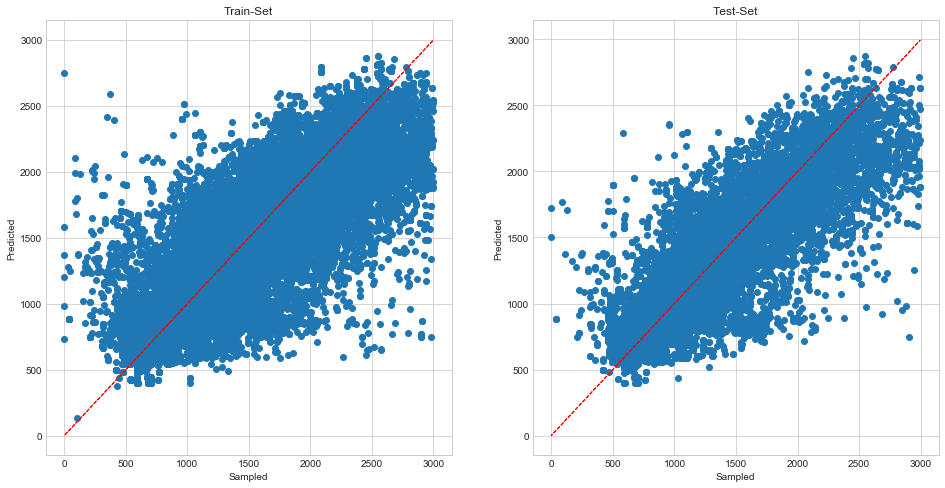

In [29]:
model_name = models[2]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = Lasso(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

<hr>

### Elastic-Net Regressor

Elastic-net is a linear regression model that combines the penalties of Lasso (L1) and Ridge (L2).<br>

<div><img src="https://miro.medium.com/max/1312/1*oECWmvwOKotaAA0czR30vg.png" width="500"/></div>

Model: elasticnet_regressor
CV Mean Accuracy:  0.7153199581511815
CV STD Accuracy:  0.0022334074641178173 

Train Accuracy:  0.7164464550001712
Test Accuracy:  0.716800989573736


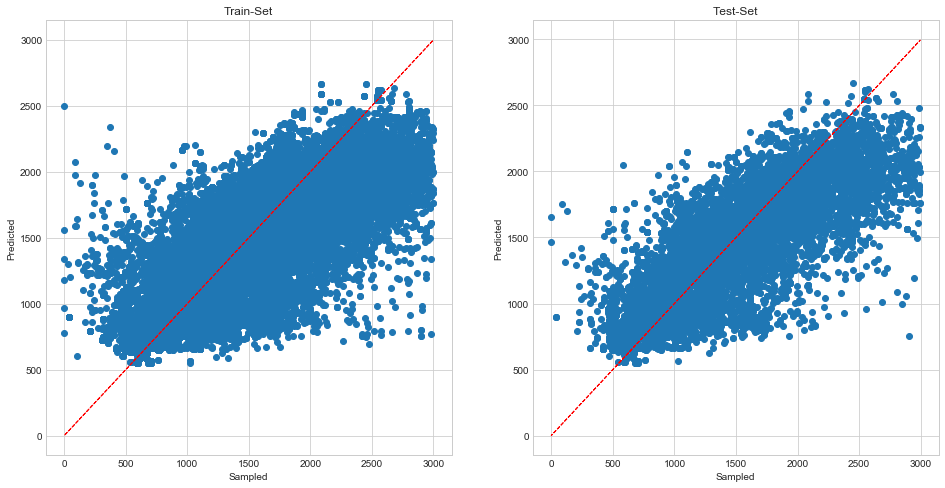

In [30]:
model_name = models[3]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = ElasticNet(alpha=1, l1_ratio=0.5)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                              'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, 
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

### Support Vector Regressor

The method of Support Vector Classification can be extended to solve regression problems, termed as Support Vector Regression.<br>
The model produced by support vector classification (classic SVM) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin.<br>
Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.<br>
In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold<br>

<div><img src="https://miro.medium.com/max/1400/1*rs0EfF8RPVpgA-EfgAq85g.jpeg" width="500"/></div>

Model: supportvect_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarni

CV Mean Accuracy:  0.7205769559769878
CV STD Accuracy:  0.0026860200315482466 

Train Accuracy:  0.7229941441192291
Test Accuracy:  0.723495289410103


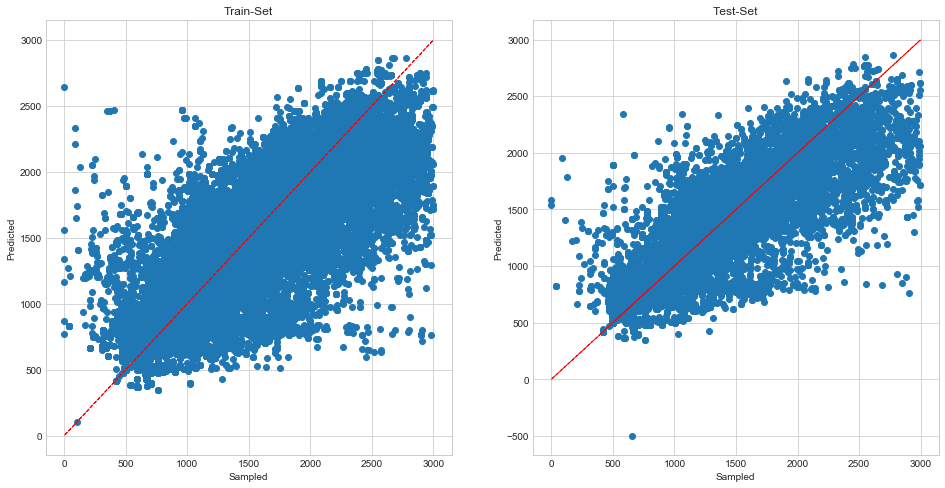

In [31]:
model_name = models[4]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = LinearSVR(random_state=0, tol=1e-5)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

<hr>

# Trees

### Decision Tree Regressor

<div><img src="https://miro.medium.com/max/1630/1*XZ220vTa7rN8ccJZZNe09w.png" width="500"/></div>

Model: decisiontree_regressor
CV Mean Accuracy:  0.8716913533920607
CV STD Accuracy:  0.0015499831542286583 

Train Accuracy:  0.9692043502662818
Test Accuracy:  0.88745328469533


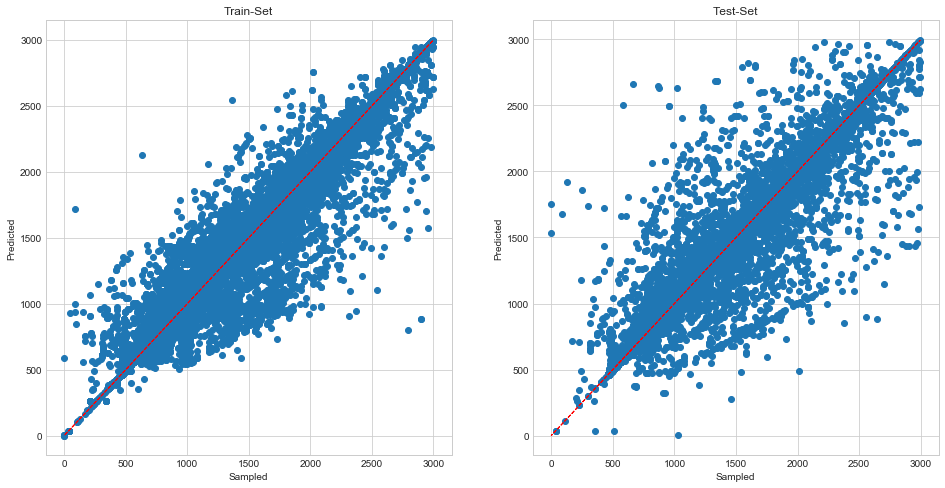

In [32]:
model_name = models[5]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = DecisionTreeRegressor(random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

Feature Importances

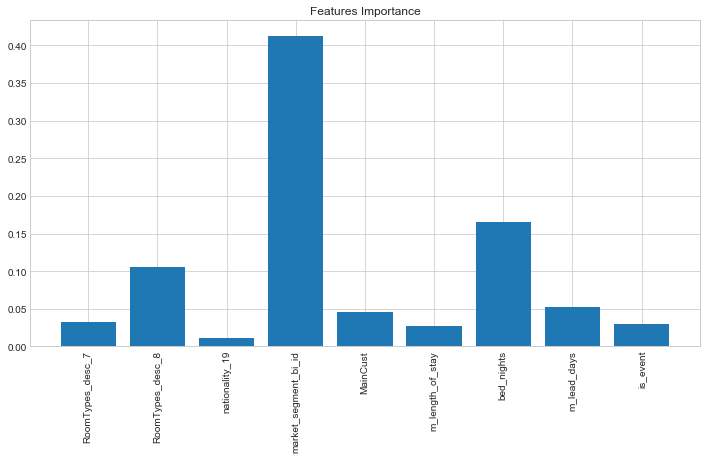

In [33]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

Tree Visualization

In [34]:
%%script false --no-raise-error

plot_tree(model)

<hr>

### Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting<br>

<div><img src="https://databricks.com/wp-content/uploads/2015/01/Ensemble-example.png" width="500"/></div>

Model: randomforest_regressor
CV Mean Accuracy:  0.5850621402120595
CV STD Accuracy:  0.016499830438439042 

Train Accuracy:  0.5812991154771513
Test Accuracy:  0.5809099589550002


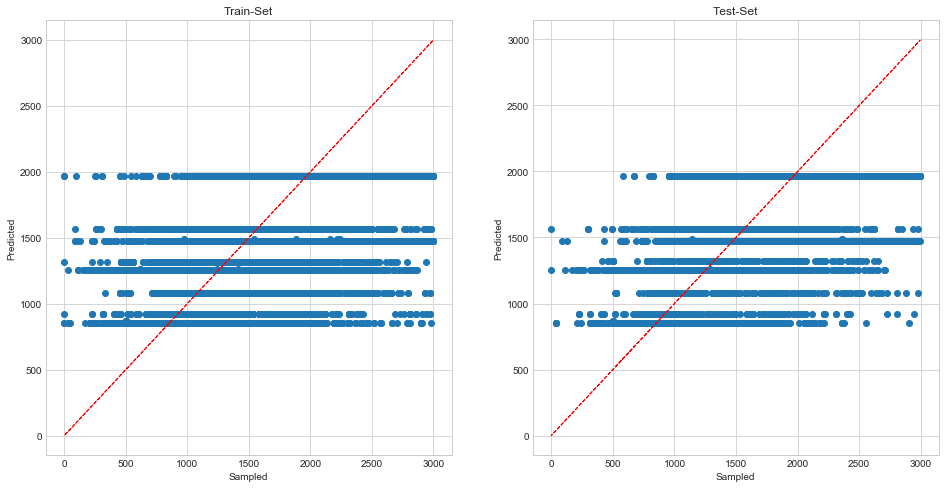

In [35]:
model_name = models[6]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = RandomForestRegressor(max_depth=2, random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

Feature Importances

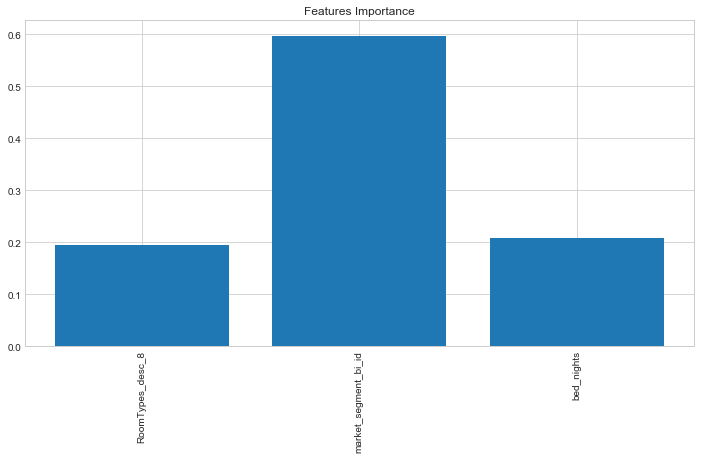

In [36]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

<hr>

### XGBoost Regressor

XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.<br>

<div><img src="https://miro.medium.com/max/1000/0*tzKt_ABz5rRrsGoW.jpg" width="500"/></div>

Model: xgboost_regressor
CV Mean Accuracy:  0.8098501880351494
CV STD Accuracy:  0.0024134421242639763 

Train Accuracy:  0.8151716121762456
Test Accuracy:  0.8142654117613931


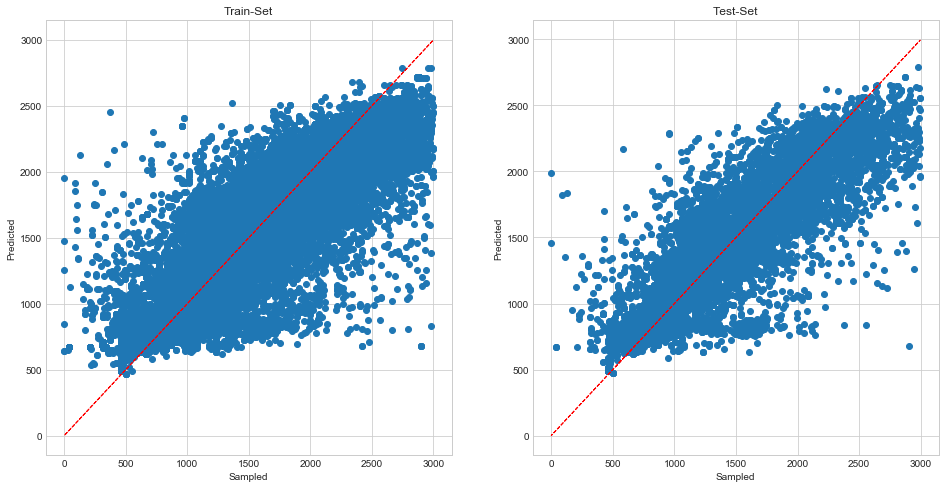

Base Score:  0.5


In [37]:
model_name = models[7]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, n_estimators=100)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'max_depth': [2,4,6],
                              'n_estimators': [50,100,200]}, 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)
    
print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

print('Base Score: ', model.base_score)

Feature Importances

Text(0.5, 1.0, 'Features Importance')

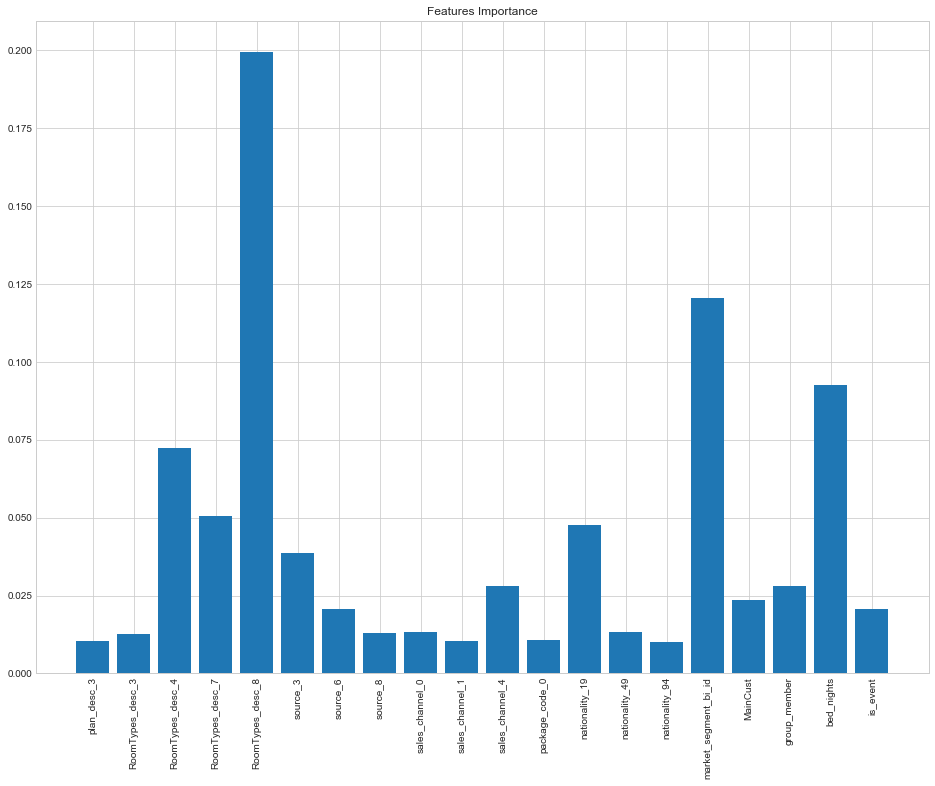

In [38]:
feature_import_thr = 0.01
feature_import_val = model.feature_importances_[model.feature_importances_ > feature_import_thr]
feature_import_lbl = X_train.columns[model.feature_importances_ > feature_import_thr]

plt.figure(figsize=(16,12))
plt.bar(feature_import_lbl, feature_import_val)
plt.xticks(rotation='vertical')
plt.title('Features Importance')

<hr>

# Neural Networks

### Multi-layer Perceptron

A Multi-layer Perceptron (MLP) Regression System is a multilayer feedforward neural network training system that implements multi-layer perceptron regression algorithm to solve a Multi-layer Perceptron Regression Task.<br>

<div><img src="https://miro.medium.com/max/1400/1*-IPQlOd46dlsutIbUq1Zcw.png" width="500"/></div>

Model: mlp_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

CV Mean Accuracy:  -1.213356104752422e+35
CV STD Accuracy:  1.2920448752276059e+35 

Train Accuracy:  0.9116799981045169
Test Accuracy:  -1.611228066278479e+35


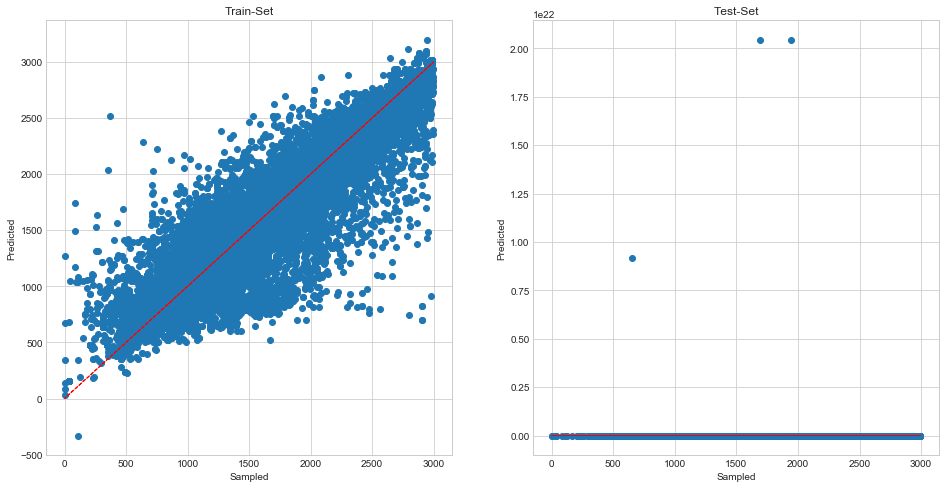

In [39]:
model_name = models[8]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = make_pipeline(StandardScaler(),
                          MLPRegressor(hidden_layer_sizes=(100, 100),
                                       tol=1e-2, 
                                       max_iter=500,
                                       random_state=0))

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model(model, X_train, y_train, y_test, y_pred)

### Tensorflow ANN

Place-Holder

<hr>

# Statistical Forecasting

### SARIMAX

Place-Holder

### FBProphet

Place-Holder

<hr>

# Summary

In [40]:
summary = { 'train_accuracy': {}, 
            'test_accuracy': {} } 

for model_name in models:
    
    model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

    if path.isfile(model_file):
        
        model = joblib.load(model_file)
        
        summary['train_accuracy'][model_name] = model.score(X_train, y_train)
        summary['test_accuracy'][model_name] = model.score(X_test, y_test)
          
summary_df = pd.DataFrame(summary).astype(float).round(4)
summary_df[abs(summary_df)>1] = 0
display(summary_df)

,train_accuracy,test_accuracy
linear_regressor,0.7360,0.0000
ridge_regressor,0.7361,0.7366
lasso_regressor,0.7361,0.7367
elasticnet_regressor,0.7164,0.7168
supportvect_regressor,0.7230,0.7235
decisiontree_regressor,0.9692,0.8875
randomforest_regressor,0.5813,0.5809
xgboost_regressor,0.8152,0.8143
mlp_regressor,0.9117,0.0000


<hr>

In [41]:
print('Completed')

Completed
